### This notebook generate the line benefits from the operational cost

In [901]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [902]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [903]:
#%% Setting up the path a cases
DirName  = os.getcwd()

CSV_name =  'OC_fy_1'

opt_cluster = 100

CaseName_Base     = '9n'
# CaseName_ByStages = CaseName_Base + '_ByStages'
CaseName_ByStages = CaseName_Base+'_ByStages_nc'+str(opt_cluster)

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [904]:
df_1 = pd.read_csv(_path_0+'/3.Out/Estimations/'+'Estimated_'+CSV_name+'.csv', index_col=0)

In [905]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [906]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [907]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_6_cac1,Network_Line_In_Node_1_Node_6_cac2,Network_Line_In_Node_1_Node_6_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Network_Line_In_Node_2_Node_6_cac1,Network_Line_In_Node_2_Node_6_cac2,Network_Line_In_Node_2_Node_6_cac3,Network_Line_In_Node_3_Node_4_cac1,...,Network_Line_In_Node_6_Node_7_cac3,Network_Line_In_Node_6_Node_8_cac1,Network_Line_In_Node_6_Node_8_cac2,Network_Line_In_Node_6_Node_8_cac3,Network_Line_In_Node_7_Node_8_cac1,Network_Line_In_Node_7_Node_8_cac2,Network_Line_In_Node_7_Node_8_cac3,Network_Line_In_Node_8_Node_9_cac1,Network_Line_In_Node_8_Node_9_cac2,Network_Line_In_Node_8_Node_9_cac3
0,-0.001483,-0.003175,-0.005708,-0.000642,-0.000931,-0.001116,-0.000649,-0.001464,-0.002313,-0.000343,...,0.002488,0.000596,0.000993,0.001449,-0.000324,-0.000741,-0.001090,-0.000029,-0.000056,-0.000035
1,-0.001715,-0.003287,-0.005860,-0.000735,-0.001062,-0.001306,-0.000743,-0.001585,-0.002434,-0.000477,...,0.002225,0.000456,0.000857,0.001291,-0.000465,-0.000891,-0.001228,0.000010,-0.000017,-0.000064
2,-0.001697,-0.003887,-0.006182,-0.000706,-0.001033,-0.001294,-0.000736,-0.001574,-0.002422,-0.000440,...,0.002241,0.000448,0.000858,0.001319,-0.000441,-0.000867,-0.001196,0.000242,0.000214,0.000160
3,-0.001682,-0.004421,-0.006135,-0.000688,-0.001015,-0.001291,-0.000750,-0.001572,-0.002420,-0.000417,...,0.002249,0.000433,0.000851,0.001317,-0.000426,-0.000852,-0.001151,0.000327,0.000401,0.000373
4,-0.001681,-0.004407,-0.006051,-0.000687,-0.001014,-0.001310,-0.000773,-0.001582,-0.002431,-0.000419,...,0.002236,0.000410,0.000832,0.001369,-0.000426,-0.000852,-0.000766,0.000318,0.000519,0.000513


In [908]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [909]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_6_cac1,Network_Line_In_Node_1_Node_6_cac2,Network_Line_In_Node_1_Node_6_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Network_Line_In_Node_2_Node_6_cac1,Network_Line_In_Node_2_Node_6_cac2,Network_Line_In_Node_2_Node_6_cac3,Network_Line_In_Node_3_Node_4_cac1,...,Network_Line_In_Node_6_Node_7_cac3,Network_Line_In_Node_6_Node_8_cac1,Network_Line_In_Node_6_Node_8_cac2,Network_Line_In_Node_6_Node_8_cac3,Network_Line_In_Node_7_Node_8_cac1,Network_Line_In_Node_7_Node_8_cac2,Network_Line_In_Node_7_Node_8_cac3,Network_Line_In_Node_8_Node_9_cac1,Network_Line_In_Node_8_Node_9_cac2,Network_Line_In_Node_8_Node_9_cac3
LoadLevel,,,,,,,,,,,,,,,,,,,,,
01-01 00:00:00+01:00,-0.001483,-0.003175,-0.005708,-0.000642,-0.000931,-0.001116,-0.000649,-0.001464,-0.002313,-0.000343,...,0.002488,0.000596,0.000993,0.001449,-0.000324,-0.000741,-0.001090,-0.000029,-0.000056,-0.000035
01-01 01:00:00+01:00,-0.001715,-0.003287,-0.005860,-0.000735,-0.001062,-0.001306,-0.000743,-0.001585,-0.002434,-0.000477,...,0.002225,0.000456,0.000857,0.001291,-0.000465,-0.000891,-0.001228,0.000010,-0.000017,-0.000064
01-01 02:00:00+01:00,-0.001697,-0.003887,-0.006182,-0.000706,-0.001033,-0.001294,-0.000736,-0.001574,-0.002422,-0.000440,...,0.002241,0.000448,0.000858,0.001319,-0.000441,-0.000867,-0.001196,0.000242,0.000214,0.000160
01-01 03:00:00+01:00,-0.001682,-0.004421,-0.006135,-0.000688,-0.001015,-0.001291,-0.000750,-0.001572,-0.002420,-0.000417,...,0.002249,0.000433,0.000851,0.001317,-0.000426,-0.000852,-0.001151,0.000327,0.000401,0.000373
01-01 04:00:00+01:00,-0.001681,-0.004407,-0.006051,-0.000687,-0.001014,-0.001310,-0.000773,-0.001582,-0.002431,-0.000419,...,0.002236,0.000410,0.000832,0.001369,-0.000426,-0.000852,-0.000766,0.000318,0.000519,0.000513


In [910]:
ddf_1 = diff_df_1.stack()

In [911]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [912]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [913]:
ddf_1.head()

Value
LoadLevel            Execution                                   
01-01 00:00:00+01:00 Network_Line_In_Node_1_Node_6_cac1 -0.001483
                     Network_Line_In_Node_1_Node_6_cac2 -0.003175
                     Network_Line_In_Node_1_Node_6_cac3 -0.005708
                     Network_Line_In_Node_2_Node_3_cac1 -0.000642
                     Network_Line_In_Node_2_Node_3_cac2 -0.000931

In [914]:
ddf_1 = ddf_1.reset_index()

In [915]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [916]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [917]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
314491,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac2,-0.000726,1900-12-30 23:00:00
314492,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac3,-0.001037,1900-12-30 23:00:00
314493,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac1,-0.000029,1900-12-30 23:00:00
314494,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac2,-0.000002,1900-12-30 23:00:00
314495,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac3,0.000474,1900-12-30 23:00:00


#### Getting day of year and month

In [918]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [919]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac1,-0.001483,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac2,-0.003175,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac3,-0.005708,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,-0.000642,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,-0.000931,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [920]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [921]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
314491,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac2,-0.000726,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_7_Node_8_cac2_23
314492,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac3,-0.001037,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_7_Node_8_cac3_23
314493,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac1,-0.000029,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac1_23
314494,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac2,-0.000002,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac2_23
314495,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac3,0.000474,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac3_23


In [922]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [923]:
table.tail()

Variable   Network_Line_In_Node_1_Node_6_cac1_0  \
Month Day                                         
12    360                             -0.002550   
      361                             -0.002219   
      362                             -0.001899   
      363                             -0.001879   
      364                             -0.001755   

Variable   Network_Line_In_Node_1_Node_6_cac1_1  \
Month Day                                         
12    360                             -0.002334   
      361                             -0.001714   
      362                             -0.001978   
      363                             -0.001950   
      364                             -0.001756   

Variable   Network_Line_In_Node_1_Node_6_cac1_10  \
Month Day                                          
12    360                              -0.001801   
      361                              -0.001773   
      362                              -0.013951   
      363                              -0.013862   
      364                              -0.009039   

Variable   Network_Line_In_Node_1_Node_6_cac1_11  \
Month Day                                          
12    360                              -0.001778   
      361                              -0.001841   
      362                              -0.014260   
      363                              -0.014532   
      364                              -0.011039   

Variable   Network_Line_In_Node_1_Node_6_cac1_12  \
Month Day                                          
12    360                              -0.001705   
      361                              -0.001858   
      362                              -0.014286   
      363                              -0.005571   
      364                               0.000075   

Variable   Network_Line_In_Node_1_Node_6_cac1_13  \
Month Day                                          
12    360                              -0.002503   
      361                              -0.001827   
      362                              -0.014100   
      363                              -0.002634   
      364                               0.000666   

Variable   Network_Line_In_Node_1_Node_6_cac1_14  \
Month Day                                          
12    360                              -0.003710   
      361                              -0.001692   
      362                              -0.002785   
      363                              -0.001819   
      364                              -0.001931   

Variable   Network_Line_In_Node_1_Node_6_cac1_15  \
Month Day                                          
12    360                              -0.004051   
      361                              -0.001696   
      362                              -0.001820   
      363                              -0.001730   
      364                              -0.001878   

Variable   Network_Line_In_Node_1_Node_6_cac1_16  \
Month Day                                          
12    360                              -0.004224   
      361                              -0.001768   
      362                              -0.001691   
      363                              -0.002524   
      364                              -0.001609   

Variable   Network_Line_In_Node_1_Node_6_cac1_17  ...  \
Month Day                                         ...   
12    360                              -0.003706  ...   
      361                              -0.001758  ...   
      362                              -0.001534  ...   
      363                              -0.001586  ...   
      364                              -0.001553  ...   

Variable   Network_Line_In_Node_8_Node_9_cac3_21  \
Month Day                                          
12    360                               0.000606   
      361                               0.000288   
      362                              -0.004460   
      363                              -0.002835   
      364        

In [924]:
table = table.reset_index()

In [925]:
table = table.set_index(['Day'])

In [926]:
table.tail()

Variable,Month,Network_Line_In_Node_1_Node_6_cac1_0,Network_Line_In_Node_1_Node_6_cac1_1,Network_Line_In_Node_1_Node_6_cac1_10,Network_Line_In_Node_1_Node_6_cac1_11,Network_Line_In_Node_1_Node_6_cac1_12,Network_Line_In_Node_1_Node_6_cac1_13,Network_Line_In_Node_1_Node_6_cac1_14,Network_Line_In_Node_1_Node_6_cac1_15,Network_Line_In_Node_1_Node_6_cac1_16,...,Network_Line_In_Node_8_Node_9_cac3_21,Network_Line_In_Node_8_Node_9_cac3_22,Network_Line_In_Node_8_Node_9_cac3_23,Network_Line_In_Node_8_Node_9_cac3_3,Network_Line_In_Node_8_Node_9_cac3_4,Network_Line_In_Node_8_Node_9_cac3_5,Network_Line_In_Node_8_Node_9_cac3_6,Network_Line_In_Node_8_Node_9_cac3_7,Network_Line_In_Node_8_Node_9_cac3_8,Network_Line_In_Node_8_Node_9_cac3_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,-0.002550,-0.002334,-0.001801,-0.001778,-0.001705,-0.002503,-0.003710,-0.004051,-0.004224,...,0.000606,0.000586,0.000425,0.000901,0.001755,0.001855,0.001282,0.000809,0.000758,0.000710
361,12,-0.002219,-0.001714,-0.001773,-0.001841,-0.001858,-0.001827,-0.001692,-0.001696,-0.001768,...,0.000288,0.000052,-0.000165,0.000938,0.001255,0.001188,0.001048,-0.000204,0.000140,0.000082
362,12,-0.001899,-0.001978,-0.013951,-0.014260,-0.014286,-0.014100,-0.002785,-0.001820,-0.001691,...,-0.004460,0.000217,0.000038,0.000954,0.001171,0.000933,0.000381,0.000124,0.000098,-0.000115
363,12,-0.001879,-0.001950,-0.013862,-0.014532,-0.005571,-0.002634,-0.001819,-0.001730,-0.002524,...,-0.002835,0.000314,0.000166,0.000234,0.000364,0.000421,0.000728,0.000320,-0.000108,-0.000198
364,12,-0.001755,-0.001756,-0.009039,-0.011039,0.000075,0.000666,-0.001931,-0.001878,-0.001609,...,-0.002758,0.000423,0.000474,0.000737,0.000706,0.000771,0.000783,0.000424,0.000139,0.000212


#### Split data table into data X and class labels y

In [927]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [928]:
print(X)
print(y)

[[-1.4833360e-03 -1.7150060e-03 -2.3603140e-03 ...  4.9156000e-04
   1.1519200e-03  1.4510000e-03]
 [-1.5422140e-03 -1.9211640e-03 -1.4394680e-02 ... -6.7235000e-05
  -3.3644000e-04 -3.0021070e-03]
 [-2.1838850e-03 -2.3703860e-03  1.0199100e-03 ... -4.9971000e-04
  -8.4154300e-04 -1.3943166e-03]
 ...
 [-1.8988850e-03 -1.9780240e-03 -1.3950930e-02 ...  1.2363600e-04
   9.7781000e-05 -1.1475500e-04]
 [-1.8788860e-03 -1.9497580e-03 -1.3862296e-02 ...  3.2027100e-04
  -1.0814000e-04 -1.9790300e-04]
 [-1.7549100e-03 -1.7558760e-03 -9.0394000e-03 ...  4.2441400e-04
   1.3886600e-04  2.1152300e-04]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  

## PCA step by step

#### Standardizing of the data

In [929]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [930]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.00138293+0.00000000e+00j -0.02052954+0.00000000e+00j
  -0.0645125 +0.00000000e+00j ... -0.00998361-6.56154832e-04j
  -0.00998361+6.56154832e-04j -0.00301213+0.00000000e+00j]
 [ 0.00442324+0.00000000e+00j -0.02898454+0.00000000e+00j
  -0.10379567+0.00000000e+00j ... -0.00201391+1.55636803e-04j
  -0.00201391-1.55636803e-04j -0.00141845+0.00000000e+00j]
 [-0.0439624 +0.00000000e+00j -0.01402633+0.00000000e+00j
   0.00943645+0.00000000e+00j ... -0.00191511+2.42349868e-05j
  -0.00191511-2.42349868e-05j -0.00470005+0.00000000e+00j]
 ...
 [-0.03465129+0.00000000e+00j -0.00824241+0.00000000e+00j
   0.0119303 +0.00000000e+00j ...  0.03466144-1.89679779e-03j
   0.03466144+1.89679779e-03j  0.01563756+0.00000000e+00j]
 [-0.03407827+0.00000000e+00j -0.03960057+0.00000000e+00j
   0.0204568 +0.00000000e+00j ...  0.01165445-3.49439525e-03j
   0.01165445+3.49439525e-03j -0.03391255+0.00000000e+00j]
 [-0.03002971+0.00000000e+00j -0.03570299+0.00000000e+00j
   0.02775149+0.00000000e+00

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [931]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [932]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
307.87481134744337
76.8553592017012
54.283772767109014
41.22341692554539
25.676232392700154
24.734262684237464
20.210809898948636
18.428142855787545
17.223835855740447
16.320019684623535
13.59479565658461
11.88675867927615
11.164302706699555
9.696177233458142
9.426040910917216
9.106029281939099
8.228696039864012
7.5541428204512755
6.915655152599873
6.309761885594191
6.282720619252759
5.900257832018464
5.39888030536149
5.23143421562974
4.809748358345895
4.710278732447268
4.329899625877271
4.133430086252321
3.980817069393369
3.943983582001564
3.5929677725183033
3.522885767850229
3.3657063859343777
3.2297994161295387
3.0542751700626805
2.9474482100840738
2.817820577352911
2.769631216651229
2.6535046858085902
2.5835111487582125
2.434930565246359
2.3807040853127615
2.3171736630987185
2.2114396892566766
2.151263892881609
2.0782987811748126
1.9779861019934815
1.9433271703370711
1.9171161676038722
1.8294036488532879
1.7158305090180526
1.6912358187050631
1.64189

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [933]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [934]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

(35.535764053953585+0j) 0
(44.40662263092039+0j) 1
(50.672206140555026+0j) 2
(55.43032717992372+0j) 3
(58.393949088803375+0j) 4
(61.24884624310047+0j) 5
(63.58163393938862+0j) 6
(65.7086612645854+0j) 7
(67.69668413789182+0j) 8
(69.58038604364526+0j) 9
(71.14953503865321+0j) 10
(72.52153767162064+0j) 11
(73.81015243382173+0j) 12
(74.92931208473789+0j) 13
(76.01729185257689+0j) 14
(77.06833499123172+0j) 15
(78.01811389540559+0j) 16
(78.89003399735404+0j) 17
(79.68825808300019+0j) 18
(80.41654828843069+0j) 19
(81.14171731595052+0j) 20
(81.82274142850606+0j) 21
(82.44589515728043+0j) 22
(83.04972179427219+0j) 23
(83.60487628084104+0j) 24
(84.14854970749141+0j) 25
(84.64831872337507+0j) 26
(85.12541068044594+0j) 27
(85.5848876201176+0j) 28
(86.04011313658413+0j) 29
(86.45482343541913+0j) 30
(86.86144467503097+0j) 31
(87.24992383473226+0j) 32
(87.62271623528903+0j) 33
(87.975249140869+0j) 34
(88.31545178263885+0j) 35
(88.6406924437535+0j) 36
(88.96037095529081+0j) 37
(89.26664582077353+0j) 3

Then

c:\Users\ealvarezq\Miniconda3\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


c:\Users\ealvarezq\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


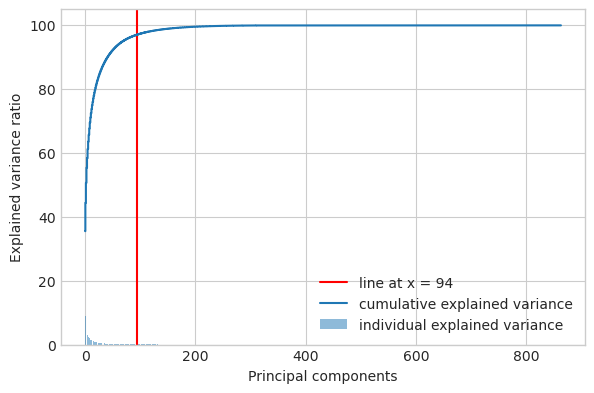

In [935]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [936]:
labels = np.unique(y, axis=0)

In [937]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

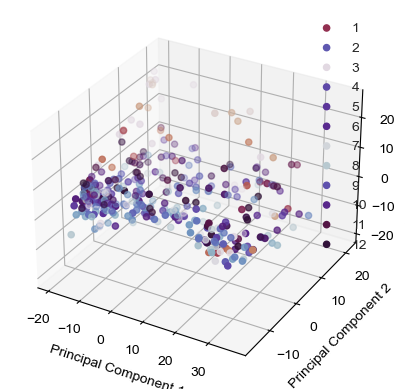

In [938]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

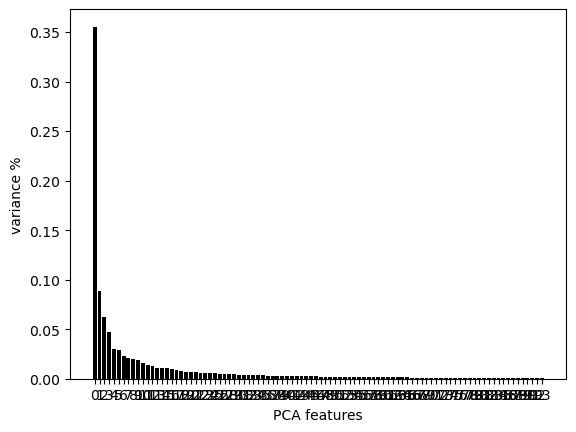

In [939]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [940]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [941]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,-16.846533,-6.407790,0.552358,2.066132,0.284070,-2.002486,-0.821334,-0.082116,-1.123756,2.307054,...,-0.346375,-0.491375,0.301429,-0.358489,1.170857,-0.047185,0.290398,-0.968872,-0.198425,0.002936
1,3.893248,-2.157963,-7.550692,-8.055774,1.528308,-4.520316,8.008453,4.971202,2.931825,1.164715,...,0.626409,-0.286718,-1.034591,0.724021,0.681552,0.867402,-1.566217,0.508852,0.655376,0.169247
2,-6.728534,11.675019,0.912866,3.472804,4.071369,-12.395874,7.506483,-4.139321,3.505846,-2.795400,...,-0.229410,-0.048440,-0.573544,0.755776,0.179929,0.698397,-0.413870,0.440944,1.167879,-0.858238
3,-9.479354,0.229014,-2.915781,2.320212,3.579622,-5.565137,7.999838,-4.153237,1.362115,1.294385,...,-0.897458,0.059349,-0.425514,1.074800,-0.142948,0.237746,0.704028,-1.092692,0.132924,-0.246929
4,0.478428,-4.822478,-1.310077,-14.412475,5.483692,1.876980,6.107567,-1.466210,4.324645,-2.476140,...,-1.174017,0.102204,-0.700870,0.559901,1.559110,1.145110,-0.274537,-1.192219,-0.548945,-0.104557


### Getting the optimal number of clusters

In [942]:
# ks = range(1, max_cluster)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters: model
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(PCA_components.iloc[:,:i])
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
# plt.show()

In [943]:
# opt_cluster = 0
# for k in range(len(inertias)-1):
#     diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
#     if diff > 0.1:
#         opt_cluster += 1
#     else:
#         break
# print("Optimal number of clusters: ", opt_cluster)

In [944]:
# with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(6, 4))
#     plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
#     # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
#             # label='individual explained variance')
#     plt.step(range(len(inertias)), inertias, where='mid',
#              label='cumulative inertia')
    
#     plt.ylabel('Inertia')
#     plt.xlabel('Number of clusters, k')
#     plt.legend(loc='best')
#     plt.tight_layout()
# plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
# plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [945]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\ealvarezq\Miniconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...


: 